In [1]:
%pylab inline
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets

Populating the interactive namespace from numpy and matplotlib


In [2]:
import anndata
import leidenalg
import napari
import skimage
import tifffile
import cv2
from pathlib import Path
from skimage import exposure
from ipywidgets import GridspecLayout

# Introduction

### Goal
__The goal of this script is to facilitate antibody titration in IMC__

This script helps identifying, for each tested marker, the positive and negative cells (based on clustering or on gating). The signal and noise levels are then calculated to help choosing the ideal concentration for each antibody. 

### Antibody titration 
For titration, an antibody mix is generated and a serial dilution is performed.  
Different sections (or different areas of the same section) are then stained with the different dilutions (relative concentrations).  
Finally, these sections are imaged by IMC.

### Image preprocessing
The `.mcd` files generated in IMC can be preprocessed using [steinbock](https://github.com/BodenmillerGroup/steinbock).  
Steinbock preprocessing allows to segment the images, measure single-cell marker inteisites and export the data to a readable format.  
This script assumes that IMC data preprocessing was performed with `steinbock` using default parameters. If other settings were used, part of this script may have to be adapted.
At the end of `steinbock` preprocessing, the data have to be exported in the `AnnData` format.

For reference, the following `steinbock` command can be used (adjust the path and steinbock version):
```
$ alias steinbock="docker run -v /path/to/your/data:/data -v /tmp/.X11-unix:/tmp/.X11-unix -v ~/.Xauthority:/home/steinbock/.Xauthority:ro -u $(id -u):$(id -g) -e DISPLAY ghcr.io/bodenmillergroup/steinbock:0.10.2"
$ steinbock preprocess imc images --hpf 50
$ steinbock segment deepcell --minmax
$ steinbock measure intensities
$ steinbock measure regionprops
$ steinbock export anndata --intensities intensities --data regionprops
```

Full `steinbock` documentation can be found here: https://bodenmillergroup.github.io/steinbock/v0.10.2.  

### Script usage
This should be run downstream of `steinbock` script performs the following tasks:

1. Import data (exported by `steinbock` as `AnnData` object(s)).
2. Calculate UMAP and generate some quality control plots.
3. Cluster the cells.
4. Facilitate the selection of clusters corresponding to positive and negative cells using either clustering (__4.1__) or gating (__4.2__).
5. Display images to make sure that the selection of positive and negative cells is correct.
6. Calculate the signal, noise, and signal-to-noise ratio.
7. Export the titration results.

__Paragraphs 4 to 6 have to be repeated for each marker__

# Parameters

It is expected that the mcd files and ROIs have been named in a consistent manner, in particular the mcd file names OR the ROI description must contain a number corresponding to the dilution factor / relative concentration of the antibody mix that was used to stain the section or section area.  

__The naming schemes that were applied for naming the mcd(s) and ROIs should be indicated here.__  
Example: if three slides were used with a three-fold antibody-mix dilution series (1:1, 1:3, 1:9), the mcd files could be named: `XXX_1.00`, `XXX_0.33`, and `XXX_0.11`.  
The corresponding naming scheme would be: `mcdName_elements = ['slide_name', 'concentration']`.  
__Note__ the part of the name corresponding to the relative concentration should always be called `concentration`.

In [3]:
# Steinbock output directory
data_path = Path('/home/ubuntu/Data2/Pilot/titration/islet2/')

# Parse the .mcd file name (scheme for naming the .mcd files)
mcdName_elements = ['donor_id', 'panel']
mcdName_separator = '_'

# Parse the ROI description (scheme for naming the different ROIs in the .mcd file)
roiName_elements = ['panelname', 'concentration']
roiName_separator = '_'

# Parse the tiff file name (no change needed, only adds acquisition id to the list)
imgName_elements = mcdName_elements + ['acq_id']

__Parameter check__  
It is assumed that the defaults steinbock folder structure and file names were used.  
If changes were made or if you get any error message here, adapt the parameters.

In [4]:
# Parameters
panel_filename = 'panel.csv'
image_metadata_filename = 'images.csv'
anndata_extension = '.h5ad'
img_extension = ('.tif', '.tiff')
anndata_object = data_path / ('objects' + anndata_extension)
img_folder = data_path / 'img'
mask_folder = data_path / 'masks'
img_files = [f for f in Path.iterdir(img_folder) if str(f).lower().endswith(img_extension)]
mask_files = [f for f in Path.iterdir(mask_folder) if str(f).lower().endswith(img_extension)]

# Checks
if(not(Path.exists(data_path))):
    raise FileNotFoundError("The data_path folder was not found")
    
if(not(Path.exists(anndata_object))):
    raise FileNotFoundError("The anndata file/folder was not found")
    
if(not(Path.exists(img_folder))):
    raise FileNotFoundError("The img folder was not found")
    
if(not(Path.exists(mask_folder))):
    raise FileNotFoundError("The mask folder was not found")
    
if(not(Path.exists(data_path / panel_filename))):
    raise FileNotFoundError("The panel.csv file was not found")
    
if(not(data_path / image_metadata_filename)):
    raise FileNotFoundError("The images.csv file was not found")
    
if len(img_files) < 1:
    raise FileNotFoundError("No image found in the img folder")
    
if len(mask_files) < 1:
    raise FileNotFoundError("No mask found in the masks folder")
    
if (len(img_files) != len(mask_files)):
    raise FileNotFoundError("Different number of images and masks")

# 1. Data preparation

## Load the data

### Load image acquisition metadata and antibody panel

In [5]:
# Image metadata
image_metadata = pd.read_csv(data_path / image_metadata_filename)

# Panel
panel = pd.read_csv(data_path / panel_filename)
if not('keep' in panel.columns):
    print("The panel should contain a `keep` column to define which channels are retained in `steinbock`.")
panel = panel.loc[panel.keep == 1]
panel

number channel  tubeNb species                   target          vendor  \
0        0   In115     NaN     NaN               Hyaluronan           Merck   
1        1   Pr141  2228.0  rabbit                     WFS1           LSBio   
2        2   Nd142  1677.0  rabbit           Chromogranin_A           Abcam   
3        3   Nd143  2193.0  rabbit            Complement_C3           Abcam   
4        4   Nd144  1132.0  rabbit  Proprotein_Convertase_2       Millipore   
5        5   Nd145  2194.0  rabbit                    XBP1           Thermo   
6        6   Nd146  1676.0  rabbit            Synaptophysin           Abcam   
7        7   Sm147  2141.0  rabbit                   HIF_1a           Abcam   
8        8   Nd148  1048.0  rabbit                  p_STAT1             CST   
9        9   Sm149  2195.0  rabbit                   IRE1?            Novus   
10      10   Nd150  1756.0   mouse                 Amylase            Sigma   
11      11   Eu151  2196.0  rabbit                  PFKFB3            Abcam   
12      12   Sm152  1758.0  rabbit                C_Peptide             CST   
13      13   Eu153  2197.0  rabbit                   p_NRF2           Abcam   
14      14   Sm154  1051.0   mouse               Proinsulin           Abcam   
15      15   Gd155  1760.0  rabbit                     Pdx1           Abcam   
16      16   Gd156   922.0  rabbit              Proglucagon             CST   
17      17   Gd158  2180.0   mouse                   TXNIP            Novus   
18      18   Tb159  2198.0   mouse                Perlecan            Sigma   
19      19   Gd160  2038.0  rabbit              PD_L1_CD274           Abcam   
20      20   Dy161  2242.0   mouse                    PTPRN     R&D Systems   
21      21   Dy162  1855.0   mouse            CD45RO_CD45RA       Biolegend   
22      22   Dy163  2181.0  rabbit                    NFkB              CST   
23      23   Dy164  1608.0  rabbit                    IDO1            Abcam   
24      24   Ho165  2182.0  rabbit                    IkBa            Abcam   
25      25   Er166  1761.0   mouse                 ST8SIA1        Millipore   
26      26   Er167  2249.0  rabbit               Collagen_I           Abcam   
27      27   Er168  2015.0    goat                   LYVE1      R&D Systems   
28      28   Tm169  1124.0  rabbit                   Nkx6_1             CST   
29      29   Er170  2035.0   mouse          Cytokeratin_19            Sigma   
30      30   Yb171  1849.0  rabbit                PVR_CD155             CST   
31      31   Yb172  1888.0  rabbit                     p21        CST_Abcam   
32      32   Yb173  1152.0   mouse              E_Cadherin   BD Biosciences   
33      33   Lu175  2122.0  rabbit                     p_Rb             CST   
34      34   Yb176  1679.0  rabbit  Somatostatin_Receptor_2           Abcam   
35      35   Ir191     NaN     NaN               Iridium191             NaN   
36      36   Ir193     NaN     NaN               Iridium193             NaN   
37      37   Pt195  1876.0     rat                  Ghrelin     R&D Systems   
38      38   Pt196  1889.0   mouse             Somatostatin          Thermo   

            clone  stock  concentration  full  spill  seg_cells  seg_islets  \
0             NaN    NaN            NaN     1      1          0           0   
1             pAb  200.0           4.00     1      1          0           0   
2         EP1030Y  500.0           1.00     1      1          2           1   
3        EPR19394  500.0           2.00     1      1          0           0   
4             pAb  200.0           1.50     1      1          0           0   
5             pAb  500.0           5.00     1      1          0           0   
6           YE269  500.0           3.00     1      1          0           1   
7         EP1215Y  500.0           0.75     1      1          0           0   
8             pAb  200.0           7.50     1      1          0           0   
9             pAb  500.0           7.50     1      1 

### Load AnnData files
__List files__

In [20]:
anndata_files = [f.name for f in Path.iterdir(anndata_object) if str(f).lower().endswith(anndata_extension)]

if len(anndata_files) < 1:
    raise FileNotFoundError("No AnnData file found in the anndata folder")
else:
    print('List of anndata files found:', anndata_files)

List of anndata files found: ['6301_Islet_002.h5ad', '6301_Islet_003.h5ad', '6197_Islet_002.h5ad', '6197_Islet_003.h5ad', '6301_Islet_001.h5ad', '6197_Islet_001.h5ad']


__Read-in AnnData files__

In [105]:
ad = []

for i,file in enumerate(anndata_files):
    # Read the anndata files
    ad.append(anndata.read_h5ad(anndata_object / file))
    
    # Extract info from file names and add to the anndata observations
    imgName_values = str(file).removesuffix(anndata_extension).split(mcdName_separator)
    imgName = dict(zip(imgName_elements, imgName_values))    
    
    for valname, val in imgName.items():
        ad[i].obs[valname] = val
    
    # Add image and object ids as explicit observations
    ad[i].obs['image_id'] = '_'.join(imgName_values)
    ad[i].obs['image'] = '_'.join(imgName_values) + '.tiff'
    ad[i].obs['object_id'] = ad[i].obs_names
    ad[i].obs['object_id'] = ad[i].obs['object_id'].str.replace('Object ', '')
        
    # Make observation names unique
    ad[i].obs_names =  ad[i].obs['image_id'] + '_' + ad[i].obs['object_id']

__Concatenate AnnData files__  
AnnData files corresponding to different .mcd files are merged into a single file

In [106]:
ad = anndata.concat(ad)

### Import image metadata
__Add image metadata to the AnnData file observations__

In [107]:
ad.obs = ad.obs.merge(image_metadata, how='left', on='image').set_index(ad.obs.index)

__Parse ROI descriptions__

In [109]:
ad.obs[roiName_elements] = ad.obs['acquisition_description'].str.split('_', expand = True)
ad.obs['concentration'] = ad.obs['concentration'].astype('double')

__Check that the correct concentrations were extracted from the parsed names__

In [110]:
concentrations = np.unique(ad.obs['concentration'])
print('Relative concentrations used = ', concentrations)

Relative concentrations used =  [1. 3. 9.]


### Import antibody panel
__Add panel to the AnnData file variables__

In [111]:
if len(ad.var) == len(panel):
    ad.var_names = panel['name']
    ad.var = panel
    ad.var_names = ad.var['name']
    markers = ad.var_names
    ad.var['number'] = list(range(len(panel)))
else:
    print("Different number of rows in the panel and in ad.var",
         "\nNumber of rows in panel:", len(panel.index),
         "\nNumber of rows in the AnnData object:", len(ad.var.index))

### Transform the data
Arcinh- and log-transformation are applied and stored in the `layers` of the AnnData object.

In [112]:
ad.layers['exprs'] = np.arcsinh(ad.X)
ad.layers['log'] = np.log1p(ad.X)
ad

AnnData object with n_obs × n_vars = 30813 × 39
    obs: 'area', 'centroid-0', 'centroid-1', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'donor_id', 'panel', 'acq_id', 'image_id', 'image', 'object_id', 'width_px', 'height_px', 'num_channels', 'source_file', 'recovery_file', 'recovered', 'acquisition_id', 'acquisition_description', 'acquisition_start_x_um', 'acquisition_start_y_um', 'acquisition_end_x_um', 'acquisition_end_y_um', 'acquisition_width_um', 'acquisition_height_um', 'panelname', 'concentration'
    var: 'number', 'channel', 'tubeNb', 'species', 'target', 'vendor', 'clone', 'stock', 'concentration', 'full', 'spill', 'seg_cells', 'seg_islets', 'dimred', 'clustering', 'keep', 'deepcell', 'name'
    layers: 'exprs', 'log'

# 2. Dimensionality reduction

## Run PCA and UMAP

In [113]:
# Run PCA
sc.pp.pca(ad)

# Find nearest-neighbors
sc.pp.neighbors(ad, n_neighbors=30)

# Run UMAP
sc.tl.umap(ad)

## Plot UMAP
### Plot variables on UMAP
__Select in the list below the variables you want to visualize on UMAP.__  
The concentration is always plotted by default.

In [114]:
w_obs = widgets.SelectMultiple(
    options=ad.obs.columns[~ad.obs.columns.isin(['concentration'])],
    # value=[],
    rows=15,
    description='Observations',
    disabled=False
)
w_obs

SelectMultiple(description='Observations', options=('area', 'centroid-0', 'centroid-1', 'major_axis_length', '…

In [115]:
plot_variables = np.array(w_obs.value + ('concentration',))
ad.obs[plot_variables] = ad.obs[plot_variables].astype('category')

/home/ubuntu/miniconda3/envs/titration_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'donor_id' as categorical
/home/ubuntu/miniconda3/envs/titration_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'panel' as categorical
/home/ubuntu/miniconda3/envs/titration_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated

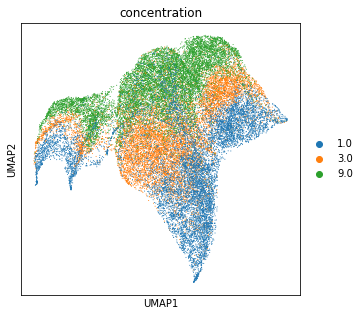

In [116]:
figsize(5,5)
for var in plot_variables:
    sc.pl.umap(ad, color=var)

### Plot channels on UMAP

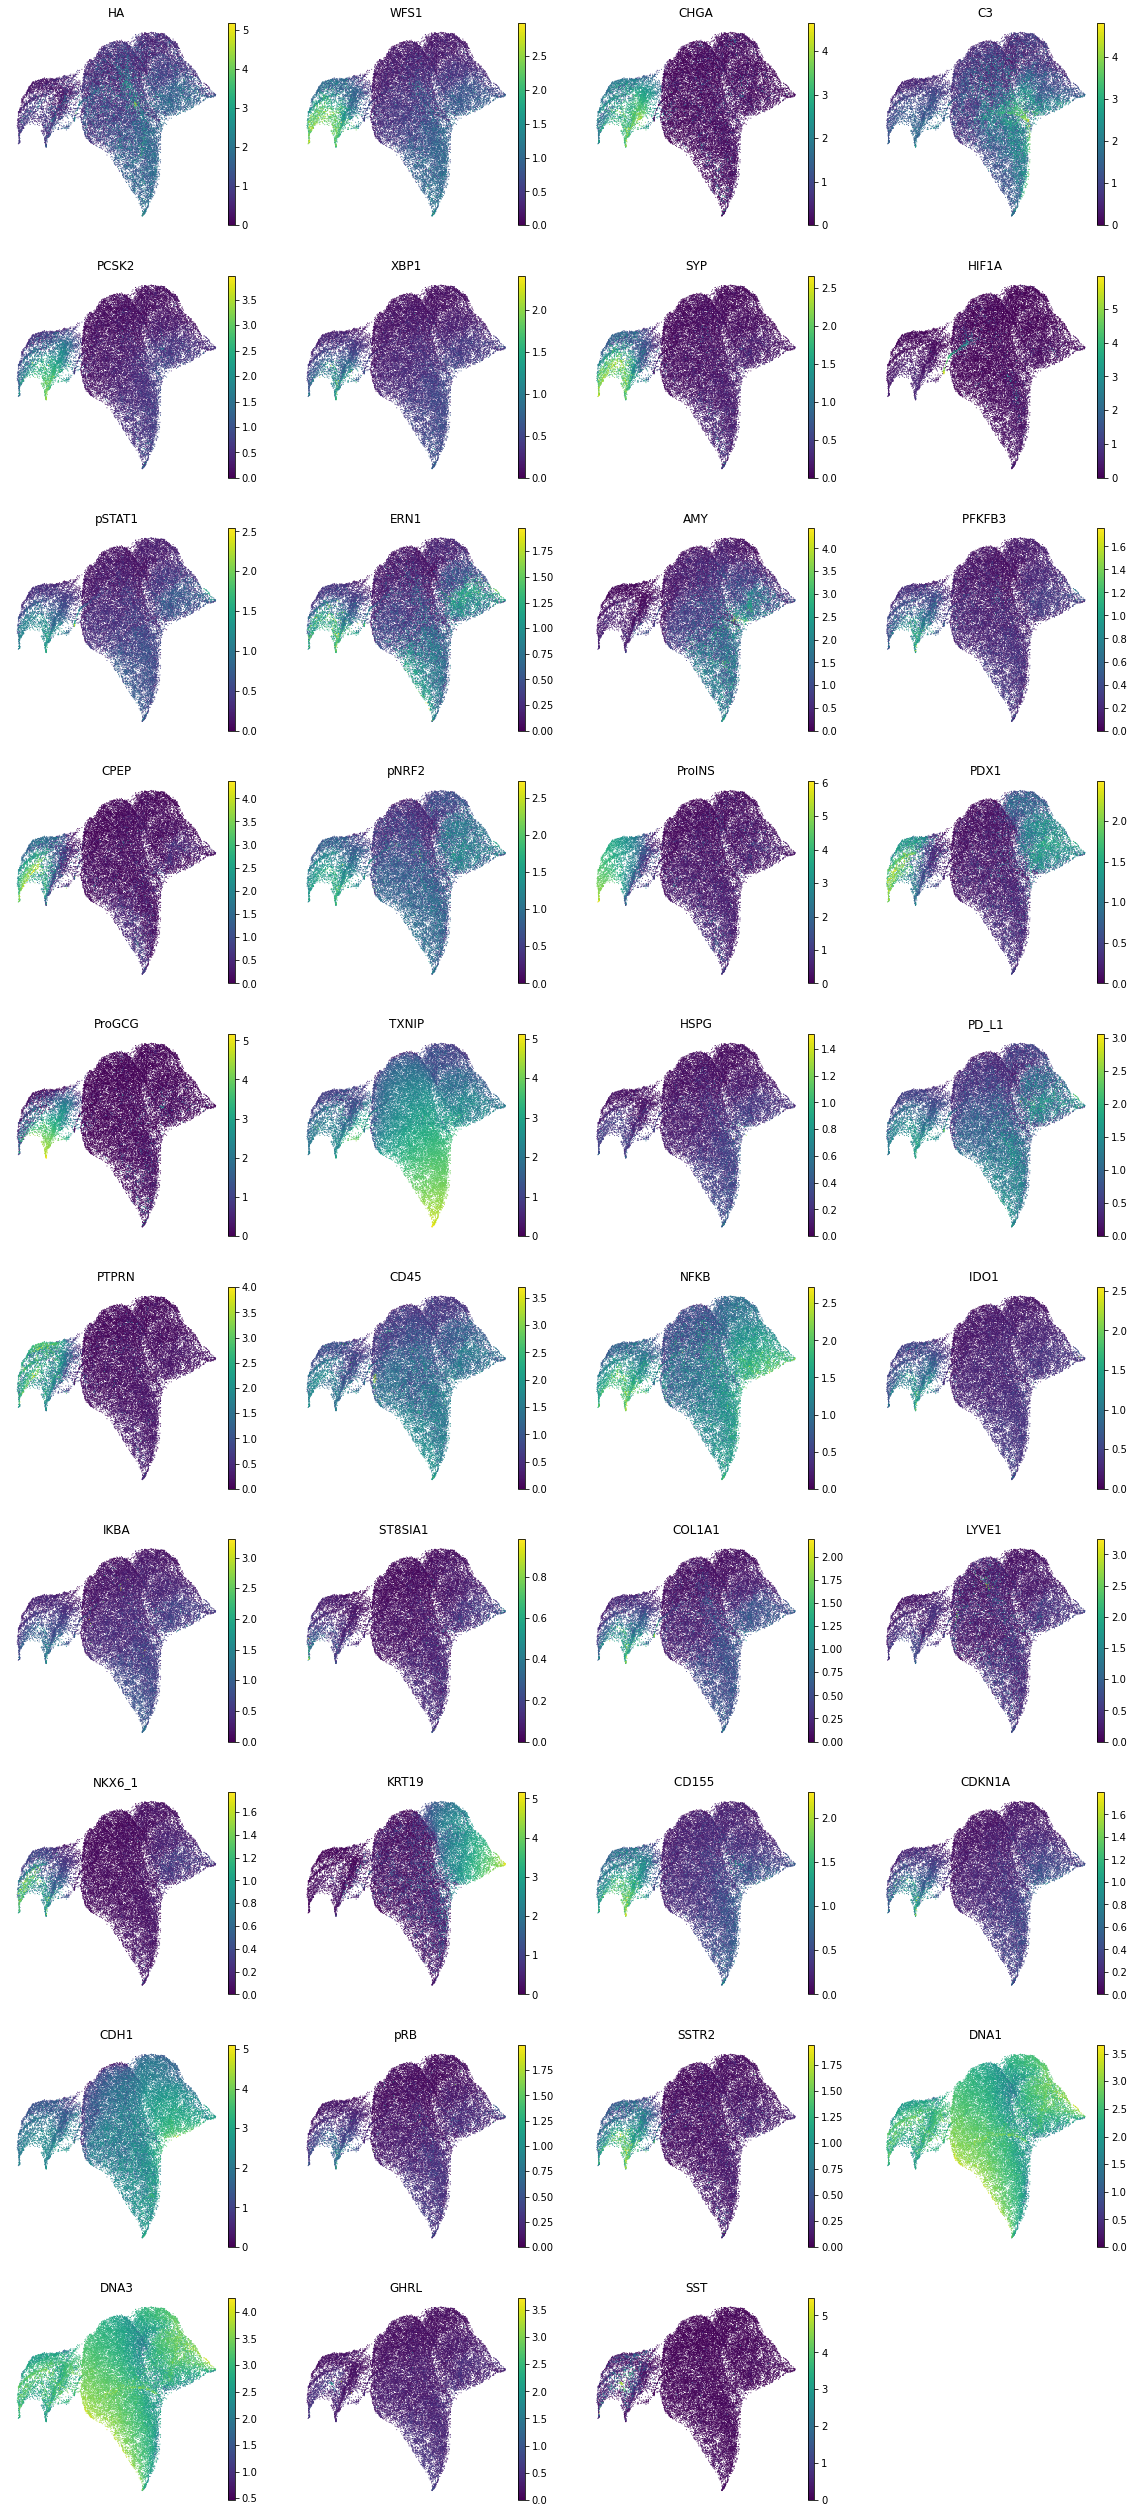

In [117]:
figsize(4,4)
sc.pl.umap(ad, layer='exprs', color=ad.var_names, gene_symbols = ad.var_names, frameon=False)

# 3. Clustering
### Run clustering and plot 
__Leiden community detection__

In [118]:
clustering_resolution = 1.5
cluster_name = 'leiden' + str(clustering_resolution)
sc.tl.leiden(ad, resolution=clustering_resolution, key_added=cluster_name)
ad.obs[cluster_name] = ad.obs[cluster_name].str.zfill(2).astype('category')

### Plot clusters
__Plot clusters on UMAP__

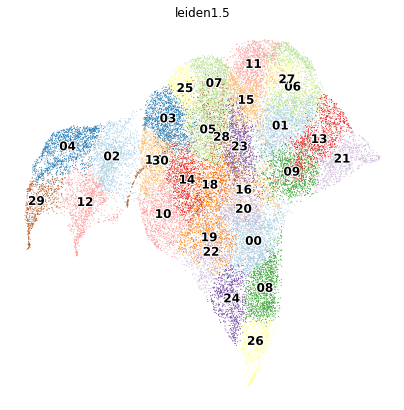

In [119]:
figsize(7,7)
sc.pl.umap(ad, color=cluster_name, add_outline=False, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,frameon=False, palette='Paired')

__Cluster heatmap__

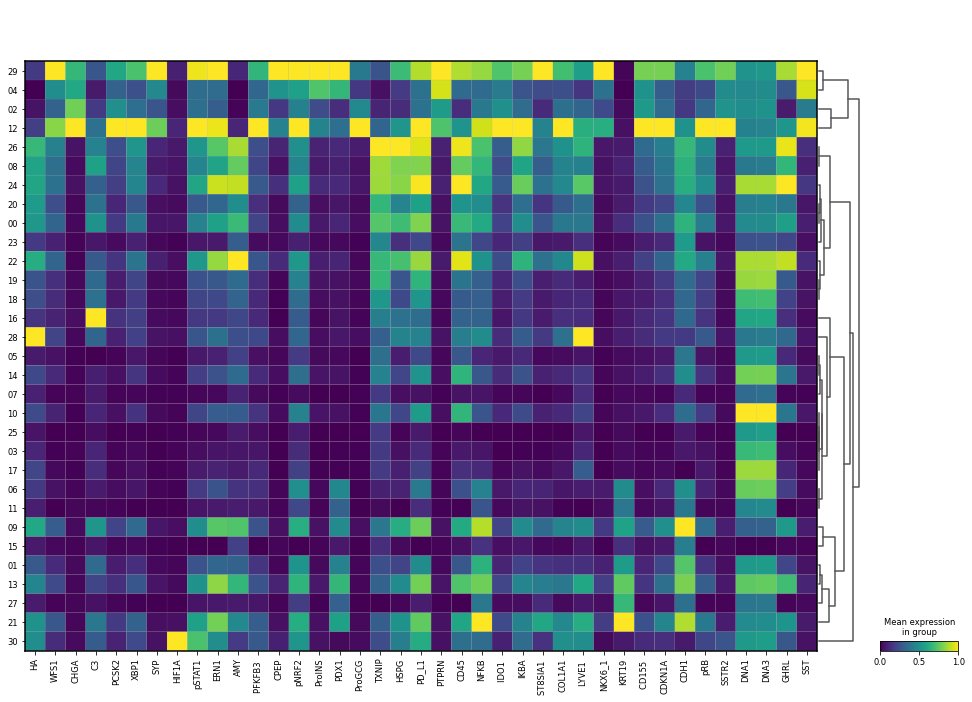

In [120]:
# Run dendrogram
sc.tl.dendrogram(ad, groupby=cluster_name, optimal_ordering=True)

# Plot heatmap
sc.pl.matrixplot(ad, ad.var_names, groupby=cluster_name, layer='exprs',
                 standard_scale = 'var', dendrogram=True)

### Calculate concentration distribution by cluster

In [121]:
cluster_distrib = ad.obs.groupby(['concentration', cluster_name]).size().to_frame('cellspercluster').reset_index()
cluster_total = ad.obs.groupby([cluster_name]).size().to_frame('totalcells').reset_index()
cluster_distrib = pd.merge(cluster_distrib, cluster_total, on=cluster_name)
cluster_distrib['fraction'] = cluster_distrib['cellspercluster'] / cluster_distrib['totalcells']

## Write / read the AnnData object
Execute only if needed

In [122]:
# # Exported AnnData file name
# anndata_fn = data_path / 'titration.h5ad'

# # Write the file
# anndata.AnnData.write(ad, filename = anndata_fn)

# # Read the file (if saved in a previous run)
# ad = anndata.read_h5ad(anndata_fn)

# # Print-out the AnnData object
# ad

# 4. Identify positive and negative cells

Positive and negative cells can be selected in two ways:
- 4.1. Select positive and negative clusters.
- 4.2. Define gates on density plots.
Simply select the marker to analyze (chunk below, one marker at a time) and run cells in either the 4.1 or the 4.2 section (different methods can be used for different markers).

### Select the marker to analyze
___Only one marker can be analyzed at a time___

In [123]:
w_marker = widgets.Select(
    options=sorted(ad.var_names),
    value=sorted(ad.var_names)[0],
    rows=20,
    description='Markers:',
    disabled=False
)
w_marker

Select(description='Markers:', options=('AMY', 'C3', 'CD155 ', 'CD45', 'CDH1', 'CDKN1A', 'CHGA', 'COL1A1', 'CP…

In [124]:
cur_marker = w_marker.value
print("The current marker is:", cur_marker)

The current marker is: HIF1A


## 4.1 Select the highest- and lowest-expressing clusters
### Plot the clusters by expression level
__Calculate the mean expression level for the current marker__

In [125]:
# Calculate mean expression
cur_dat = sc.get.obs_df(ad, keys=[cluster_name, cur_marker], layer='exprs')
grouped = cur_dat.groupby(cluster_name)
mean, var = grouped.mean(), grouped.var()
mean_exprs = mean.sort_values(by=cur_marker)

# Order the cluster distribution by expression level
cluster_distrib[cluster_name] = pd.Categorical(cluster_distrib[cluster_name], categories=array(mean_exprs.index), ordered=True)
cluster_distrib.sort_values(cluster_name, inplace=True)

__Plot the cluster distribution by concentration + Plot the clusters by increasing expression level__

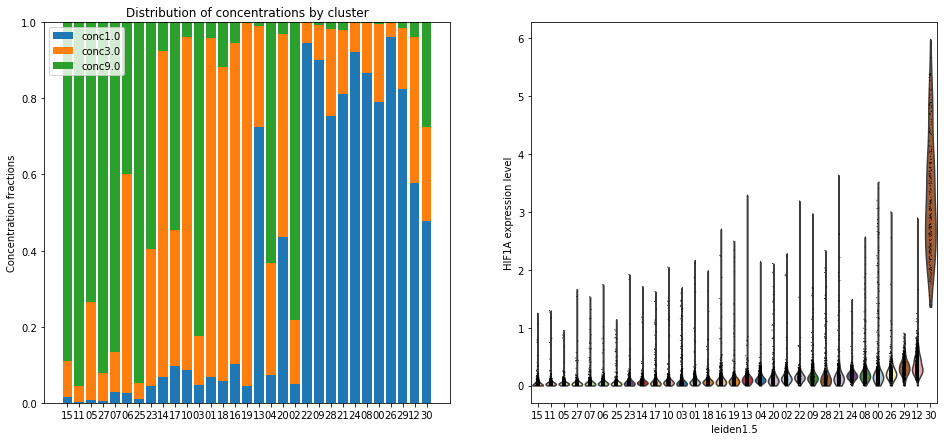

In [126]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,7))
labels = cluster_distrib[cluster_name].unique()
conc_list = []

for i,conc in enumerate(concentrations):
    conc_list.append(np.array(cluster_distrib[
        cluster_distrib['concentration'].astype(int) == int(concentrations[i])]['fraction']))

    if i == 0:
        ax1.bar(labels, conc_list[i], label='conc' + str(concentrations[i]))
    else:
        cur_conc_list = conc_list[0:i]
        ax1.bar(labels, conc_list[i], label='conc' + str(concentrations[i]),
               bottom = np.sum(cur_conc_list, axis=0))

ax1.set_ylabel('Concentration fractions')
ax1.set_title('Distribution of concentrations by cluster')
ax1.legend()

sc.pl.violin(adata=ad, keys=cur_marker, groupby=cluster_name, layer='exprs',
             order=mean_exprs.index.values, ylabel=(cur_marker + " expression level"),
             cmap='viridis_r', ax=ax2)

plt.show()

### Select the clusters

__Select clusters that are ***negative*** for the current marker__  
By default, the lowest-expressing cluster is selected.

In [127]:
w_neg = widgets.SelectMultiple(
    options=mean_exprs.index.values,
    value=(mean_exprs.index.values[0],),
    rows=20,
    description='Negative clusters:',
    disabled=False
)
w_neg

SelectMultiple(description='Negative clusters:', index=(0,), options=('15', '11', '05', '27', '07', '06', '25'…

__Select clusters that are ***positive*** for the current marker__   
By default, the highest-expressing cluster is selected.

In [128]:
w_pos = widgets.SelectMultiple(
    options=mean_exprs.index.values,
    value=(mean_exprs.index.values[-1],),
    rows=15,
    description='Positive clusters:',
    disabled=False
)
w_pos

SelectMultiple(description='Positive clusters:', index=(30,), options=('15', '11', '05', '27', '07', '06', '25…

__Add a column to identify positive and negative cells__  
The number of negative and positive cells for each concentrations are printed out.

In [129]:
# Recover the selected clusters from the interactive widgets
clusters_neg = np.array(w_neg.value)
clusters_pos = np.array(w_pos.value)

# Add a 'cluster_selection' column
ad.obs.loc[:,('clustering')] = 'Inter'
ad.obs.loc[ad.obs[cluster_name].isin(clusters_neg), 'clustering'] = 'Negative'
ad.obs.loc[ad.obs[cluster_name].isin(clusters_pos), 'clustering'] = 'Positive'

# Count cell numbers
def count_cells(method, category, _conc):
    cell_nb = len(ad.obs[(ad.obs[method] == category) & (ad.obs['concentration'] == _conc)].index)
    return(cell_nb)

cell_numbers = []
for i,conc in enumerate(concentrations):
    cell_numbers.append([count_cells('clustering', 'Negative', conc),
                         count_cells('clustering', 'Inter', conc),
                         count_cells('clustering', 'Positive', conc)])
pd.DataFrame(cell_numbers, index = concentrations, columns = ['Negative', 'Inter', 'Positive'])

Negative  Inter  Positive
1.0      1984   7732       113
3.0      8891   1748        59
9.0      9008   1213        65

### Plot the selected clusters

Variables plotted on UMAP:
- left: concentrations.
- center: expression level of the current marker.
- right: selected cells.

/home/ubuntu/miniconda3/envs/titration_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'clustering' as categorical


<AxesSubplot:title={'center':'clustering'}, xlabel='UMAP1', ylabel='UMAP2'>

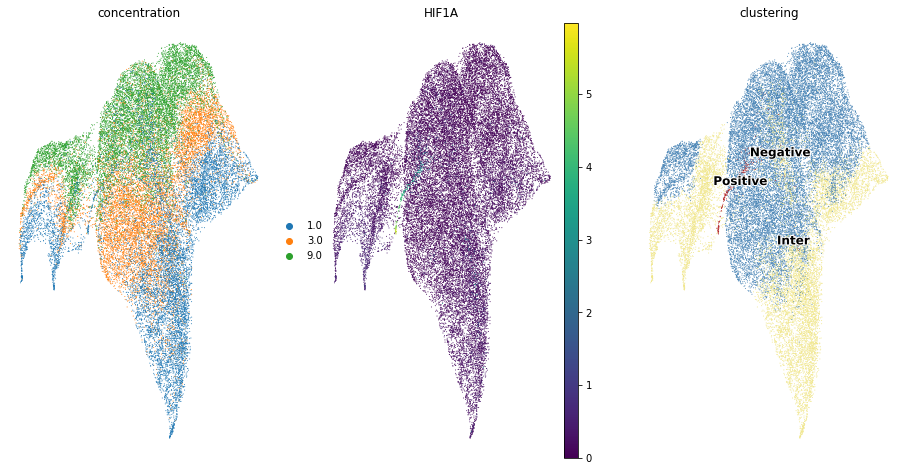

In [130]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16,8))
palette_dict = {'Negative': 'steelblue', 'Inter': 'khaki', 'Positive': 'firebrick'}

sc.pl.umap(ad, color='concentration', frameon=False, show=False, ax=ax1)
sc.pl.umap(ad, layer='exprs', gene_symbols = cur_marker,
           color=cur_marker, frameon=False, show=False, ax=ax2)
sc.pl.umap(ad, color='clustering', add_outline=False,
           legend_loc='on data', legend_fontsize=12, legend_fontoutline=2,
           frameon=False, palette=palette_dict, show=False, ax=ax3)

## 4.2 Identify positive and negative cells by gating on density plots

In [131]:
print("The current marker is:", cur_marker)

# Extract data corresponding to the current marker
dat = pd.DataFrame({'concentration': ad.obs.loc[:, 'concentration'],
                    cur_marker: ad[:, ad.var_names==cur_marker].layers['log'].flatten(),
                   'selection': None})

The current marker is: HIF1A


### Select the values for gating

The different sliders represent different concentrations and the values can be modified separately for each of them.  
- Cells with marker expression ___below___ the left value are considered ___negative___.  
- Cells with marker expression ___above___ the left value are considered ___positive___.  
- Cells in an intermediate percentile are not considered.

In [50]:
w_values = []
for i,conc in enumerate(concentrations):
    min_val = round(min(dat.loc[:, cur_marker]), 2)
    max_val = round(max(dat.loc[:, cur_marker]), 2)

    w_values.append(widgets.FloatRangeSlider(
    value=[max_val * 0.5, max_val * 0.9],
    min=min_val, max=max_val, step=0.01,
    description='Conc. ' + str(conc),
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='90%')
    ))

grid = GridspecLayout(len(concentrations),1)
for i in range(len(concentrations)):
    grid[i, :] = w_values[i]
grid

GridspecLayout(children=(FloatRangeSlider(value=(2.645, 4.761), continuous_update=False, description='Conc. 1.…

### Plot the densities and selected values
___Adjust the values in the slider above and re-run this cell if needed___

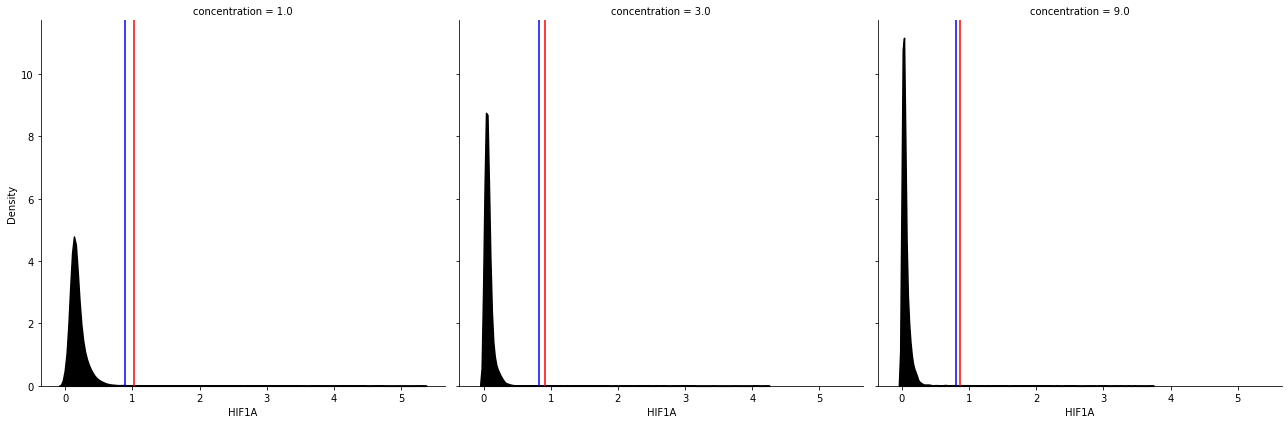

In [132]:
sel_values = pd.DataFrame(None, index = [x for x in concentrations], columns = ['bottom','top'])
for i,conc in enumerate(concentrations):
    sel_values.loc[conc, 'bottom'] = w_values[i].value[0]
    sel_values.loc[conc, 'top'] = w_values[i].value[1]
    
g = sns.FacetGrid(dat, col="concentration", aspect=1, height=6, col_wrap=len(concentrations))

# Draw the densities
g.map(sns.kdeplot, cur_marker,
      bw_adjust=.5, clip_on=False,
      fill=True, color='black', alpha=1, linewidth=1.5)

# Draw the gates
for item, ax in g.axes_dict.items():
    for i,conc in enumerate(concentrations):
        if item == conc:
            ax.axvline(x = sel_values.loc[conc, 'bottom'], color='blue')
            ax.axvline(x = sel_values.loc[conc, 'top'], color='red')

def annotate(data, **kws):
    ax = plt.gca()
g.map_dataframe(annotate)

### Identify the positive and negative cells

In [133]:
for conc in concentrations:
# Define negative and positive cells
    dat.loc[(dat['concentration'] == conc) &
            (dat[cur_marker] < sel_values.loc[conc, 'bottom']),
            'selection'] = 'Negative'
    dat.loc[(dat['concentration'] == conc) &
            (dat[cur_marker] >= sel_values.loc[conc, 'top']),
            'selection'] = 'Positive'
    dat.loc[(dat['concentration'] == conc) &
            (dat[cur_marker] >= sel_values.loc[conc, 'bottom']) &
            (dat[cur_marker] < sel_values.loc[conc, 'top']),
            'selection'] = 'Inter'

# Add a 'gating' column to the dataset
ad.obs.loc[:,('gating')] = None
ad.obs.loc[ad.obs_names.isin(dat.loc[dat['selection'] == 'Negative'].index), 'gating'] = 'Negative'
ad.obs.loc[ad.obs_names.isin(dat.loc[dat['selection'] == 'Inter'].index), 'gating'] = 'Inter'
ad.obs.loc[ad.obs_names.isin(dat.loc[dat['selection'] == 'Positive'].index), 'gating'] = 'Positive'

cell_numbers = []
for i,conc in enumerate(concentrations):
    cell_numbers.append([count_cells('gating', 'Negative', conc),
                         count_cells('gating', 'Inter', conc),
                         count_cells('gating', 'Positive', conc)])
pd.DataFrame(cell_numbers, index = concentrations, columns = ['Negative', 'Inter', 'Positive'])

Negative  Inter  Positive
1.0      9605     24       200
3.0     10589     10        99
9.0     10190      5        91

__Plot the selected cells__  
Variables plotted on UMAP:
- left: concentrations.
- center: expression level of the current marker.
- right: selected cells.

___Adjust the gates above if neeeded___

/home/ubuntu/miniconda3/envs/titration_env/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['grid', 'mean', 'var', 'annotate']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +
/home/ubuntu/miniconda3/envs/titration_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'gating' as categorical


Populating the interactive namespace from numpy and matplotlib


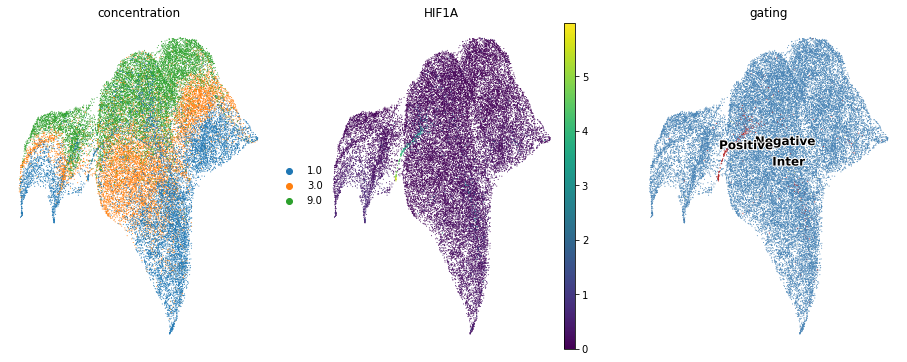

In [134]:
%pylab inline
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6))
palette_dict = {'Negative': 'steelblue', 'Inter': 'khaki', 'Positive': 'firebrick'}

ax1_dict = sc.pl.umap(ad, color='concentration', frameon=False, ax=ax1, show=False)
ax2_dict = sc.pl.umap(ad, layer='exprs', gene_symbols = cur_marker,
                      color=cur_marker, frameon=False, ax=ax2, show=False)
ax3_dict = sc.pl.umap(ad, color='gating', add_outline=False,
                      legend_loc='on data', legend_fontsize=12, legend_fontoutline=2,
                      frameon=False,palette=palette_dict, ax=ax3, show=False)

# 5. Visualize the selected cells on images

Here, images are displayed to confirm that the selection of negative and positive cells is correct.  

## Parameters

__Select the method that was used to identifiy the negative and positive cells__

In [135]:
w_method = widgets.RadioButtons(
    options=['clustering', 'gating'],
    description='Method:',
    disabled=False
)
w_method

RadioButtons(description='Method:', options=('clustering', 'gating'), value='clustering')

__Define values for random image cropping__   
For readability, the images are cropped before being displayed (choose arbitrarily large values to avoid cropping).

In [136]:
# Width and height of the crops (change if needed)
crop_width = 500
crop_height = 500

__Select one image to display per concentration__  
By default, random images are selected. If you want to display specific image select them below, or uncomment the `np.random.seed` line to always select the same images.

In [137]:
# np.random.seed(1)
w_images = []

for i,conc in enumerate(concentrations):
    cur_images = ad.obs[['concentration', 'image_id']][ad.obs['concentration'] == concentrations[i]].drop_duplicates()
    w_images.append(widgets.RadioButtons(
        options=sorted(cur_images['image_id']),
        value=np.random.choice(cur_images['image_id']),
        description='Conc. ' + str(conc),
        disabled=False)
    )
    
grid = GridspecLayout(1, len(concentrations))
for i in range(len(concentrations)):
    grid[:, i] = w_images[i]
grid

GridspecLayout(children=(RadioButtons(description='Conc. 1.0', layout=Layout(grid_area='widget001'), options=(…

## Load images
### Load and crop the images

In [138]:
# Get the channel corresponding to the curent marker
channel = ad.var.loc[ad.var_names == cur_marker, 'number'].iloc[0]

# Get selected images
selected_images = []
for i,conc in enumerate(concentrations):
    selected_images.append(w_images[i].value)

# Get image paths
image_paths = []
mask_paths = []

for i, conc in enumerate(concentrations):
    image_paths.append([f for f in img_files if str(f.name).startswith(selected_images[i])])
    mask_paths.append([f for f in mask_files if str(f.name).startswith(selected_images[i])])
    
# Read in the images
image_list = []
mask_list = []

for i, conc in enumerate(concentrations):
    # Load the images
    image_list.append(tifffile.imread(image_paths[i]))
    mask_list.append(tifffile.imread(mask_paths[i]))
    
    if image_list[i].shape[0] != len(ad.var_names):
        print("The panel and image have a different number of channels")
        
    # Subset the channel corresponding to the curent marker
    image_list[i] = image_list[i][channel]
    
    if image_list[i].shape != mask_list[i].shape:
        print("The mask and the image have different shapes")
    
# Crop the images
crop_mask = []
for i,conc in enumerate(concentrations):
    if(shape(image_list[i])[1] > crop_width):
        rdm_x1 = np.random.randint(0, shape(image_list[i])[1] - crop_width)
        rdm_x2 = rdm_x1 + crop_width
    else:
        rdm_x1 = 0
        rdm_x2 = shape(image_list[i])[1]
        
    if(shape(image_list[i])[0] > crop_height):
        rdm_y1 = np.random.randint(0, shape(image_list[i])[0] - crop_height)
        rdm_y2 = rdm_y1 + crop_height
    else:
        rdm_y1 = 0
        rdm_y2 = shape(image_list[i])[0]
    
    crop_mask.append([rdm_y1, rdm_y2, rdm_x1, rdm_x2])

###  Mask cells
Retrieve the positive and negative cells and create a mask overlay.

In [139]:
method_column = w_method.value

positive_cells = numpy.empty(len(concentrations)).tolist()
intermediate_cells = numpy.empty(len(concentrations)).tolist()
negative_cells = numpy.empty(len(concentrations)).tolist()
mask_overlays = [0] * len(concentrations)

for i, conc in enumerate(concentrations):
    # Retrieve the ids of positive and negative cells
    ad_subset = ad[(ad.obs['concentration'] == conc) & (ad.obs['image_id'] == selected_images[i]),
                   ad.var_names == cur_marker]
    positive_cells[i] = ad_subset[ad_subset.obs[method_column] == 'Positive'].obs['object_id']
    intermediate_cells[i] = ad_subset[ad_subset.obs[method_column] == 'Inter'].obs['object_id']
    negative_cells[i] = ad_subset[ad_subset.obs[method_column] == 'Negative'].obs['object_id']
    
    # Mask the cells
    pos = np.array(positive_cells[i]).astype('int')
    inter = np.array(intermediate_cells[i]).astype('int')
    neg = np.array(negative_cells[i]).astype('int')

    mask_overlays[i] = np.empty(shape(mask_list[i]), dtype=int)
    mask_overlays[i].fill(0)
    mask_overlays[i][np.isin(mask_list[i], pos)] = 3
    mask_overlays[i][np.isin(mask_list[i], inter)] = 2
    mask_overlays[i][np.isin(mask_list[i], neg)] = 1

### Display images and masks

__Row 1:__ Selected images, the current marker is shown.

__Row 2:__ Masks plotted onto images.
Positive cells are overlaid in blue, negative cells in red and intermediate cells in yellow.

___Manually adjust image brightness and mask transparency if needed___

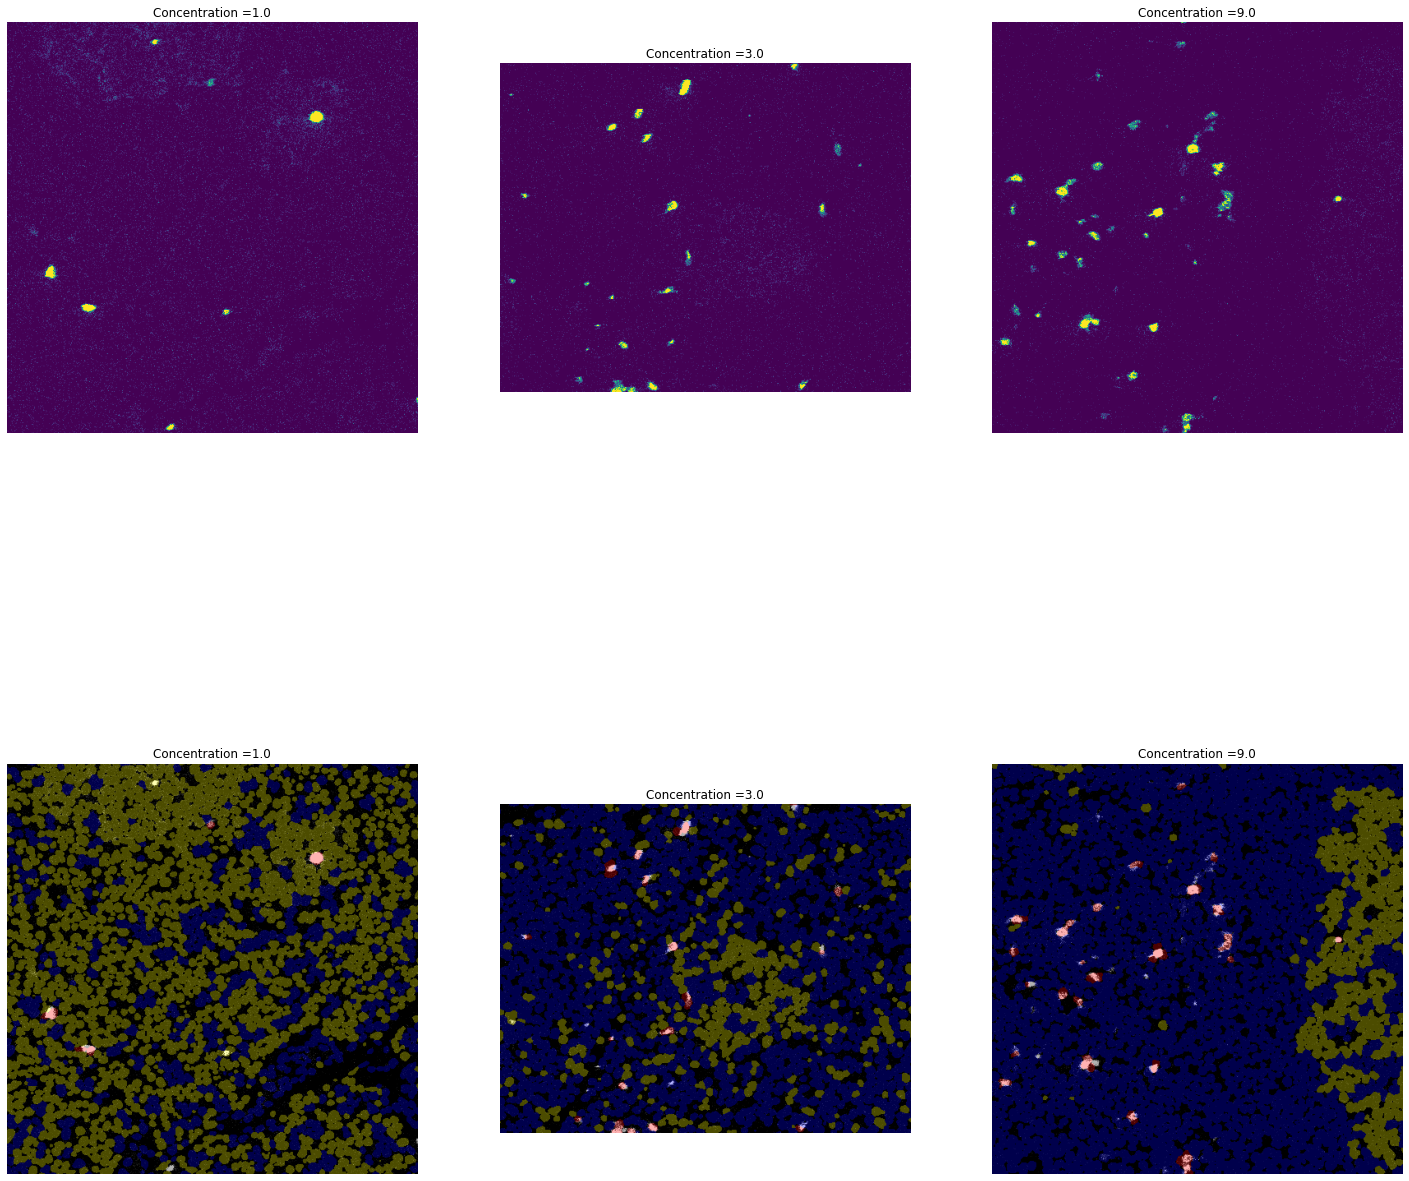

In [140]:
# Brightness and transparency
brightness = 20
transparency = 0.3

# Display images
fig, axs = plt.subplots(2, len(concentrations), figsize=(25, 25))

for i, conc in enumerate(concentrations):
    # Images
    cur_image = cv2.convertScaleAbs(image_list[i], alpha=brightness, beta=0)
    cur_image = cur_image[crop_mask[i][0]:crop_mask[i][1], crop_mask[i][2]:crop_mask[i][3]]
    axs[0,i].imshow(cur_image, cmap=plt.cm.viridis)
    axs[0,i].set_title("Concentration =" + str(conc))
    axs[0,i].axis('off')

    # Image-Mask overlay
    overlay = cur_image.copy()
    overlay = skimage.color.gray2rgb(cur_image)
    cur_mask = mask_overlays[i]
    cur_mask = cur_mask[crop_mask[i][0]:crop_mask[i][1], crop_mask[i][2]:crop_mask[i][3]]
    overlay = skimage.color.label2rgb(cur_mask, overlay, alpha=transparency, bg_label=0,
                                     colors=['blue','yellow','red'])
    axs[1,i].imshow((overlay*255).astype('uint8'))
    axs[1,i].set_title("Concentration =" + str(conc))
    axs[1,i].axis('off')
    
plt.show()

### View images and masks with napari
There is also the option to view the images with napari (no cropping and interactive zoom / mask overlay).  

First, select the concentration you want to see:

In [141]:
# w_conc = widgets.Select(
#     options=concentrations,
#     value=concentrations[0],
#     description='Concentrations:',
#     disabled=False
# )
# w_conc

In [142]:
# cur_conc = np.where(concentrations == w_conc.value)
# print("Current concentration = ", double(concentrations[cur_conc]))

__Start napari viewer__  
Positive cells are shown in white and negative cells in black on the mask

In [143]:
# viewer = napari.Viewer() 
# viewer.add_image(image_list[int(cur_conc[0])], name = 'IMC image ' + cur_marker)
# viewer.add_image(mask_overlays[int(cur_conc[0])], name = 'Cell mask')
# napari.run()

# 6. Calculate and plot signal and noise

### Calculate signal/noise based on selected clusters

__Retrieve positive and negative cells names__

In [144]:
positive_cells = numpy.empty(len(concentrations)).tolist()
negative_cells = numpy.empty(len(concentrations)).tolist()

for j, conc in enumerate(concentrations):
    ad_subset = ad[ad.obs['concentration'] == conc, ad.var_names == cur_marker]
    positive_cells[j] = ad_subset[ad_subset.obs[w_method.value] == 'Positive'].obs_names
    negative_cells[j] = ad_subset[ad_subset.obs[w_method.value] == 'Negative'].obs_names

__Calculate average expression levels of positive and negative cells__   
The caclulation is based on raw IMC counts.

In [145]:
signal = []
noise = []

for j, conc in enumerate(concentrations):
    signal.append(np.ndarray.item(
        np.mean(ad[ad.obs_names.isin(positive_cells[j]), cur_marker].X))) #layers['exprs'])))
    noise.append(np.ndarray.item(
        np.mean(ad[ad.obs_names.isin(negative_cells[j]), cur_marker].X))) #layers['exprs'])))
    
signal = pd.Series(signal, index = concentrations)
noise = pd.Series(noise, index = concentrations)

results = { 'signal': signal, 'noise': noise }
results = pd.DataFrame(results, index=concentrations)

__Calculate signal-to-noise ratio__

In [146]:
# Calculate signal-to-noise ratio
results['SignalToNoise'] = (results['signal'] / results['noise']).astype('float64')

# Adjust variable types
results['marker'] = cur_marker
results['concentration'] = concentrations
results['signal'] = results['signal'].astype('double')
results['noise']  = results['noise'].astype('double')
results['concentration'] = np.array(results['concentration'], dtype='double')

# Transform the dataset
results_long = results.melt(id_vars = ('marker', 'concentration'), var_name='type', value_name='meanExpr')

### Plot the results

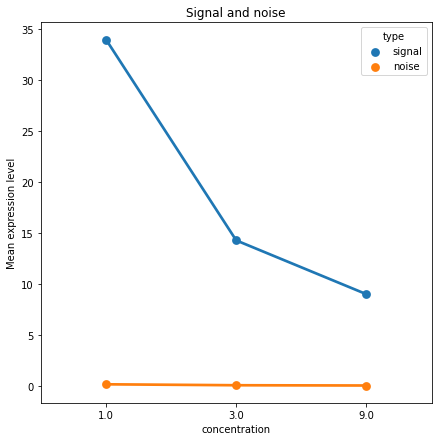

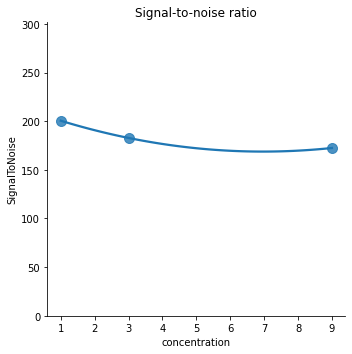

In [147]:
figsize(7,7)
g1 = sns.pointplot(
    data=results_long[(results_long['type'].isin(['signal','noise'])) &
                      (results_long['marker'] == cur_marker)],
    x='concentration', y='meanExpr', hue='type', style='type'
)
g1.set(title="Signal and noise", ylabel="Mean expression level")

cur_results = results[results['marker'] == cur_marker]
g2 = sns.lmplot(
    data = cur_results,
    x='concentration', y='SignalToNoise', col='marker',
    order=2, ci=None, scatter_kws={"s": 100}
)
g2.set(title="Signal-to-noise ratio",
       ylim=(0, 1.5 * math.ceil(max(cur_results['SignalToNoise']))))

# 7. Aggregate and export data


### Define relative concentration for the current marker

Based on the data above, enter the ideal dilution for the current marker.  

In [148]:
final_concentration = 3.0

In [149]:
print("The chosen concentration for marker", cur_marker, "is", final_concentration)

The chosen concentration for marker HIF1A is 3.0


### Aggregate the results

A data frame is created for all the markers. It can be populated by repeating, for each marker, the cluster selection (__§4.1__) or gating (__§4.2__) steps above and by selecting the ideal concentration using the signal, noise and signal-to-noise plots (__§6__).

__Current titration results__  
Note that the values are based on the relative concentrations or dilutions indicated in the mcd file names (or ROI description). The exported numbers ___do not___ represent absolute antibody concentrations.

In [150]:
titration_results = ad.var.loc[:,('name', 'channel')]
titration_results['selected_dilution'] = None
titration_results.loc[cur_marker, 'selected_dilution'] = final_concentration
titration_results

name channel selected_dilution
name                                        
HA              HA   In115              None
WFS1          WFS1   Pr141              None
CHGA          CHGA   Nd142              None
C3              C3   Nd143              None
PCSK2        PCSK2   Nd144              None
XBP1          XBP1   Nd145              None
SYP            SYP   Nd146              None
HIF1A        HIF1A   Sm147               3.0
pSTAT1      pSTAT1   Nd148              None
ERN1          ERN1   Sm149              None
AMY            AMY   Nd150              None
PFKFB3     PFKFB3    Eu151              None
CPEP          CPEP   Sm152              None
pNRF2        pNRF2   Eu153              None
ProINS      ProINS   Sm154              None
PDX1          PDX1   Gd155              None
ProGCG      ProGCG   Gd156              None
TXNIP        TXNIP   Gd158              None
HSPG          HSPG   Tb159              None
PD_L1        PD_L1   Gd160              None
PTPRN        PTPRN   Dy161              None
CD45          CD45   Dy162              None
NFKB          NFKB   Dy163              None
IDO1         IDO1    Dy164              None
IKBA          IKBA   Ho165              None
ST8SIA1   ST8SIA1    Er166              None
COL1A1      COL1A1   Er167              None
LYVE1       LYVE1    Er168              None
NKX6_1      NKX6_1   Tm169              None
KRT19        KRT19   Er170              None
CD155       CD155    Yb171              None
CDKN1A      CDKN1A   Yb172              None
CDH1          CDH1   Yb173              None
pRB            pRB   Lu175              None
SSTR2        SSTR2   Yb176              None
DNA1          DNA1   Ir191              None
DNA3          DNA3   Ir193              None
GHRL          GHRL   Pt195              None
SST            SST   Pt196              None

### Export the results

When the process has been repeated for all the markers that need to be titered, the results can exported.  
The results are exported as `titration.csv` to the steinbock output directory (path defined at the beginning of this script). 

In [152]:
titration_results.to_csv((data_path / 'titration.csv'), index=False)